# Visualizando NDVI pelo Planetary Computer (Microsoft)

Creation: 27/08/2024 <br>
Modified: 29/08/2024 <br>
Dificuldade: Alta<br>
Criação: Sabrina P. L. P. Correa (paeslemesa@gmail.com)

Descrição: A partir de uma área de interesse (AOI) este tutorial vai ler as imagens selecionadas e calcular o NDVI. Vamos também começar a trabalhar com imagens empilhadas (stack)

References:
* https://planetarycomputer.microsoft.com/docs/quickstarts/storage/
* https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2#Example-Notebook

## Importando bibliotecas

In [2]:
#!pip install planetary_computer
#!pip install odc-stac

In [3]:
from pathlib import Path

import geopandas as gpd

import planetary_computer
import pystac_client
from pystac.extensions.eo import EOExtension as eo

import requests

from IPython.display import Image

import matplotlib.pyplot as plt

import odc.stac

## 1.Entrada de dados


A área de interesse aqui será a Lagoa Rodrigo de Freitas, no RJ.

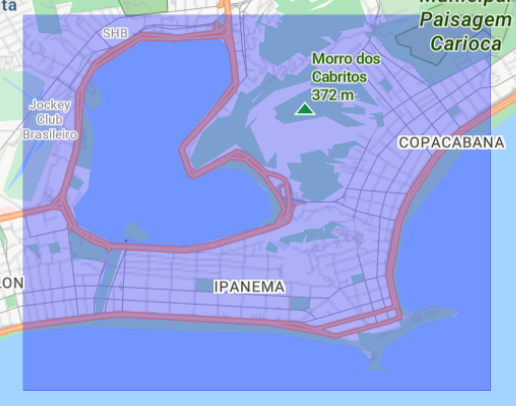

Se quiser treinar com a mesma área, você pode baixá-la em: [GitHub da AOI](https://github.com/paeslemesa/tutoriaisPython/blob/main/Dados/AOI_LagoaRodrigoDeFreaitas.geojson)

In [4]:
shpAOI = Path(r".AOI_LagoaRodrigoDeFreaitas.geojson") # Arquivo de entrada com a área de interesse no EPSG 4326

date_ini = "2023-07-04" # Data inicial no formato YYYY-MM-DD
date_end = "2024-07-26" # Data final no formato YYYY-MM-DD

cloud = 5 # Porcentagem de nuvens

bandas = ['B02', 'B03', 'B04', 'B08'] # Bandas a serem baixadas (B02: Azul, B03: Verde, B04: Vermelho, B08: Infravermelho próximo)

Primeiro vamos abrir nosso shapefile/geojson. Lembrando que pra selecionar a AOI, a gente tem que usar a AOI no crs __EPSG: 4326__.

Caso seu shapefile não esteja nesse sistema, tudo bem, nós vamos converter 😁

In [5]:
gdf = gpd.read_file(shpAOI) # Lê o arquivo de entrada

gdf = gdf.to_crs("EPSG:4326") # Converte para o sistema de coordenadas EPSG:4326 (garantindo para o caso de o arquivo estar em outro sistema de coordenadas)
bbox = gdf.total_bounds # Obtém as coordenadas da área de interesse


print(bbox)

[-43.22238359 -22.99236907 -43.18074156 -22.96114258]


## 2. Acessando as imagens disponíveis no Planetary Computer

Aqui a gente seleciona como vamos baixar a imagem:
* Data de inicio
* Data de fim
* Qual coelção a ser usada (Sentinel-2, Landsat, MODIS...)
* Se tem alguma coisa a mais que queremos adicionar, como a percentagem máxima de núvens


Em primiero momento, vamos definir o site que vamos baixar os dados.

In [6]:
# Definindo o site do filtro de busca

stac = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
#stac

Se digitarmos $stac$ (ou descomentar a linha 8 da celula acima), podemos ver que essa variável é do tipo Catálogo, como na imagem abaixo.

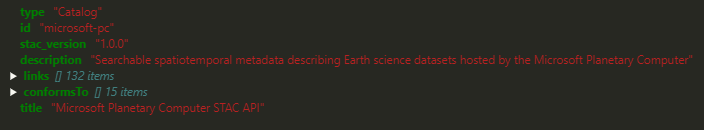


No catálogo que selecionamos, vamos agora fazer a busca considerando a área de interesse, período, coleção e nuvem.

In [7]:
# Realizando a busca no PyStac
search = stac.search(
    bbox=bbox, # Área de interesse
    datetime=f"{date_ini}/{date_end}", # Período de interesse
    collections=["sentinel-2-l2a"], # Coleção de interesse, no caso Sentinel-2 L2A. Outras coleções podem ser encontradas em https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a
    query={"eo:cloud_cover": {"lt": cloud}}, # Filtro de nuvens
)

In [8]:
# Obtendo os itens da busca
features = search.item_collection()
print("Cenas resultantes da busca: ",len(features))

Cenas resultantes da busca:  22


## 3. Lendo as imagens

Agora vamos ler todas as cenas geradas e empilhá-las num __stack__ (pilha, em português). Ao fazer isso, podemos selecionar as bandas que queremos, assim como a área de interesse determinada pela bounding box (bbox).

Se vocês descomentar a linha 6 abaixo, vai aparecer alguma coisa parecida com isso aqui:

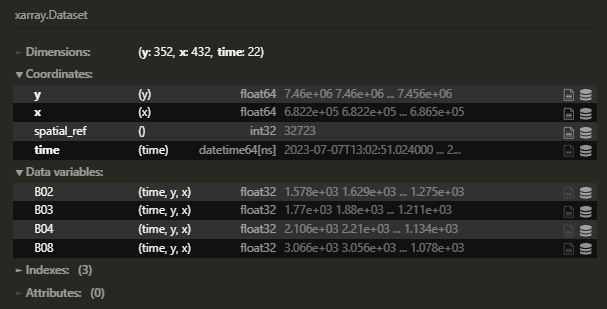

Aqui estamos selecionando todas as cenas para podermos baixá-las mais pra baixo. Mas você pode selecionar uma só!

In [9]:
data = odc.stac.stac_load(
    list(features), # lista de cenas
    bands = bandas, # Bandas a serem baixadas
    bbox=bbox # Área de interesse
)
#data

## 4. Calculando o NDVI

O NDVI (_Normalised Difference Vegetation Index_) é um índice usado para entendermos a vegetação e sua saúde*

Ele é calculado como:

$NDVI = \frac{Infravermelho Próximo + Vermelho}{Infravermelho Próximo - Vermelho}$

*Para mais informações, acesse: [EOS - NDVI](<https://eos.com/make-an-analysis/ndvi/>)

Para calcular o NDVI de uma forma simples, vamos selecionar uma cena, ou seja, um tempo.

In [10]:
tempo = 15 # valor aleatório para selecionar a imagem na qual queremos plotar

red = data["B04"].isel(time=tempo).astype("float") # Definindo a banda vermelha
nir = data["B08"].isel(time=tempo).astype("float") # Definindo a banda infravermelha próxima

ndvi = (nir - red) / (nir + red) # Calculando o NDVI

## 5. Plotando nossos resultados

Vamos agora plotar nossas imagens aqui:
* imagem em cor verdadeira
* imagem em NDVI

Text(0.5, 1.0, 'Natural Color, Lagora Rodrigo de Freitas/RJ')

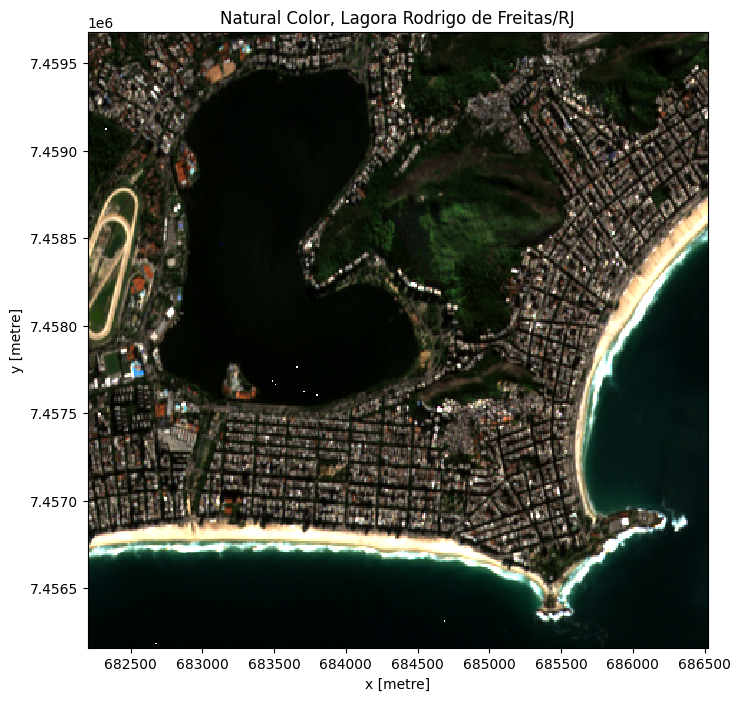

In [11]:
fig, ax = plt.subplots(1, figsize=(8, 8), sharex=True, sharey=True)

data[["B04", "B03", "B02"]].isel(time=0).to_array().plot.imshow(robust=True, ax=ax)
ax.set_title("Natural Color, Lagora Rodrigo de Freitas/RJ")


Text(0.5, 1.0, 'NDVI, Lagora Rodrigo de Freitas/RJ')

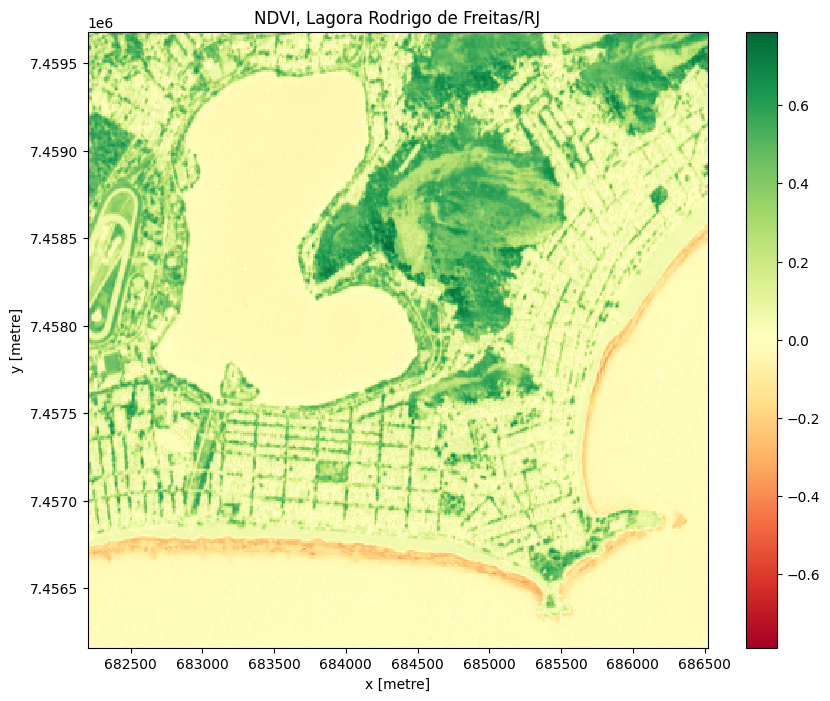

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))

ndvi.plot.imshow(ax=ax, cmap="RdYlGn")
ax.set_title("NDVI, Lagora Rodrigo de Freitas/RJ")

## 6. Baixando todas as cenas num arquivo só

🤔 Estranho começar a usar, mas o formato para imagens empilhadas (ou cubo de dados) costuma ser o __NETCDF__ (__.nc__).

😉 Não é um formato comum pra galera do geoprocessamento, mas é bastante usado por meteorologistas, oceanógrafos e etc.
Isso se dá pelo fato deles não precisarem ver todas as imagens. Para eles, em muitos casos, basta fazer os cálculos dos seus modelos.

📑Existem também alguns satélites cujos dados são liberados nesse formato, como o Sentinel-3, GOES e alguns satélites hiperespectrais.


In [14]:
nome_saida = shpAOI.with_suffix(".nc") # Nome do arquivo de saída
nome_saida

WindowsPath('E:/Pesquisa/00_Scripts/00_Tutoriais/tutoriaisPython/Dados/AOI_LagoaRodrigoDeFreaitas.nc')

In [15]:
data.to_netcdf(nome_saida) # Salvando o arquivo de saída